In [1]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = 'True'
import re 
from scipy import ndimage, misc 
from tqdm import tqdm

from skimage.transform import resize, rescale
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(0)
import cv2
import rasterio
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense ,Conv2D,MaxPooling2D ,Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

print(tf.__version__)

# Verify that TensorFlow can access the GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.13.0
Num GPUs Available:  1


### Load Raw Data

read low resolution images and high resolution images into RGB values.

In [2]:
hr_dataset_path = 'dataset/hr_dataset'
lr_dataset_path = 'dataset/lr_dataset'
hr_data = [d for d in os.listdir(hr_dataset_path) if os.path.isdir(os.path.join(lr_dataset_path, d))]
lr_data = [d for d in os.listdir(lr_dataset_path) if os.path.isdir(os.path.join(lr_dataset_path, d))]

In [3]:
print(f"Number of folders in '{hr_dataset_path}': {len(hr_data)}")
print(f"Number of folders in '{lr_dataset_path}': {len(lr_data)}")

Number of folders in 'dataset/hr_dataset': 3927
Number of folders in 'dataset/lr_dataset': 3927


In [4]:
def load_lr_images(aoi_base_name, num_revisits):
    """
    Load low-resolution images from the dataset using rasterio.

    Args:
    - aoi_base_name: Base name of the AOI folder.
    - num_revisits: Number of low-resolution images needed.

    Returns:
    - List of loaded images.
    """
    images = []
    for i in range(1, num_revisits+1):
        # lr_image_path = os.path.join('dataset/lr_dataset', aoi_base_name, 'L2A', f"{aoi_base_name}-{i}-L2A_data.TIFF")
        lr_image_path = os.path.join('dataset/lr_dataset', aoi_base_name, 'L1C', f"{aoi_base_name}-{i}-L1C_data.TIFF")
        if os.path.isfile(lr_image_path):
            try:
                with rasterio.open(lr_image_path) as src:
                    image = src.read([4, 3, 2])  # Read RGB channels if available
                    image = np.moveaxis(image, 0, -1)  # Convert to HWC format
                    images.append(image)
            except Exception as e:
                print(f"Warning: Failed to read image {lr_image_path} with error {e}")
        else:
            print(f"Warning: Low-resolution image path {lr_image_path} does not exist")
    return images

def load_hr_images(aoi):
    """
    Load high-resolution images from the dataset.

    Args:
    - aoi: Name of the AOI folder.

    Returns:
    - List of loaded images.
    """
    images = []
    hr_image_path = os.path.join('dataset/hr_dataset', aoi, f"{aoi}_ps.TIFF")
    if os.path.isfile(hr_image_path):
        try:
            with rasterio.open(hr_image_path) as src:
                image = src.read([1, 2, 3])  # Read RGB channels if available
                image = np.moveaxis(image, 0, -1)  # Convert to HWC format
                images.append(image)
        except Exception as e:
            print(f"Warning: Failed to read image {hr_image_path} with error {e}")
    else:
        print(f"Warning: Low-resolution image path {hr_image_path} does not exist")
    return images

def preprocess_image(image, target_size):
    """
    Preprocess the image for SRCNN.

    Args:
    - image: Input image.
    - target_size: Tuple of target size (width, height).

    Returns:
    - Preprocessed image.
    """
    image = cv2.resize(image, target_size)
    if np.max(image) != 0:
        image = image / np.max(image)
    
    return image

def process_aois(aoi_names, target_size_hr, target_size_lr, num_revisits):
    """
    Load and preprocess images for multiple AOIs.

    Args:
    - aoi_names: List of AOI base names.
    - target_size_hr: Tuple of target size (width, height) for high-resolution images.
    - target_size_lr: Tuple of target size (width, height) for low-resolution images.
    - num_revisits: Number of low-resolution images needed.

    Returns:
    - Dictionary with AOI names as keys and tuple of (LR images, HR images) as values.
    """
    data = {}
    for aoi_base_name in aoi_names:
        print(f"Processing AOI: {aoi_base_name}")
        lr_images = load_lr_images(aoi_base_name, num_revisits)
        hr_images = load_hr_images(aoi_base_name)

        # Preprocess images
        lr_images = [preprocess_image(img, target_size_lr) for img in lr_images]
        hr_images = [preprocess_image(img, target_size_hr) for img in hr_images]
        
        # Convert lists to numpy arrays
        lr_images = np.array(lr_images)
        hr_images = np.array(hr_images)
        
        data[aoi_base_name] = (lr_images, hr_images)
        #print(f"Low-resolution images shape for {aoi_base_name}: {lr_images.shape}")
        print(f"High-resolution images shape for {aoi_base_name}: {hr_images.shape}")
    
    return data

In [5]:
# Example usage
aoi_names = ['Amnesty POI-1-1-1', 'Amnesty POI-1-1-2'] # list of selected AOIs
target_size_hr = (500, 500)  # assuming the target size for SRCNN is (500, 500)
target_size_lr = (160, 160)
num_revisits = 1 # 1-16

aois_data = process_aois(aoi_names, target_size_hr, target_size_lr, num_revisits)

Processing AOI: Amnesty POI-1-1-1
High-resolution images shape for Amnesty POI-1-1-1: (1, 500, 500, 3)
Processing AOI: Amnesty POI-1-1-2
High-resolution images shape for Amnesty POI-1-1-2: (1, 500, 500, 3)


/Users/peinanwang/CS6140_Project/satellite_imagery_super_resolution/srcnn_satellite_images/.venv/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [6]:
aois_data['Amnesty POI-1-1-1'][0].shape

(1, 160, 160, 3)

In [7]:
aois_data['Amnesty POI-1-1-1'][1].shape

(1, 500, 500, 3)

In [ ]:
aois_data['Amnesty POI-1-1-1'][0]

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(aois_data['Amnesty POI-1-1-2'][0][0])

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(aois_data['Amnesty POI-1-1-2'][1][0])

### Prepare Training Data

In [11]:
metadata = pd.read_csv("dataset/metadata.csv")
metadata.rename(columns={metadata.columns[0]: 'aoi_name'}, inplace=True)
metadata.drop_duplicates(subset=['aoi_name'], keep='first', inplace=True)
metadata.head()

,aoi_name,n,bounds,lowres_date,highres_date,area,cloud_cover,delta,lon,lat,LCCS,SMOD,IPCC Class,LCCS class,SMOD Class
0,Amnesty POI-10-1-1,1,"[105.84161265950597, 13.147748954631947, 105.8...",2019-01-06,2019-01-27,2.5,0.06,-21,105.848905,13.154895,50,11,Forest,"Tree cover, broadleaved, evergreen, closed to ...",Rural: Very Low Dens
16,Amnesty POI-10-1-2,1,"[105.84161265950597, 13.162040839281076, 105.8...",2019-01-06,2019-01-27,2.5,0.06,-21,105.848905,13.169187,50,11,Forest,"Tree cover, broadleaved, evergreen, closed to ...",Rural: Very Low Dens
32,Amnesty POI-10-1-3,1,"[105.84161265950597, 13.176332723930203, 105.8...",2019-01-06,2019-01-27,2.5,0.06,-21,105.848905,13.183479,50,11,Forest,"Tree cover, broadleaved, evergreen, closed to ...",Rural: Very Low Dens
48,Amnesty POI-10-2-1,1,"[105.8561973580532, 13.147748954631947, 105.87...",2019-01-06,2019-01-27,2.5,0.06,-21,105.863490,13.154895,50,11,Forest,"Tree cover, broadleaved, evergreen, closed to ...",Rural: Very Low Dens
64,Amnesty POI-10-2-2,1,"[105.8561973580532, 13.162040839281076, 105.87...",2019-01-06,2019-01-27,2.5,0.06,-21,105.863490,13.169187,50,11,Forest,"Tree cover, broadleaved, evergreen, closed to ...",Rural: Very Low Dens


In [12]:
df_select = metadata[(metadata['aoi_name'].str.contains('Landcover')) & (metadata['cloud_cover'] < 0.05)]
len(df_select)

1626

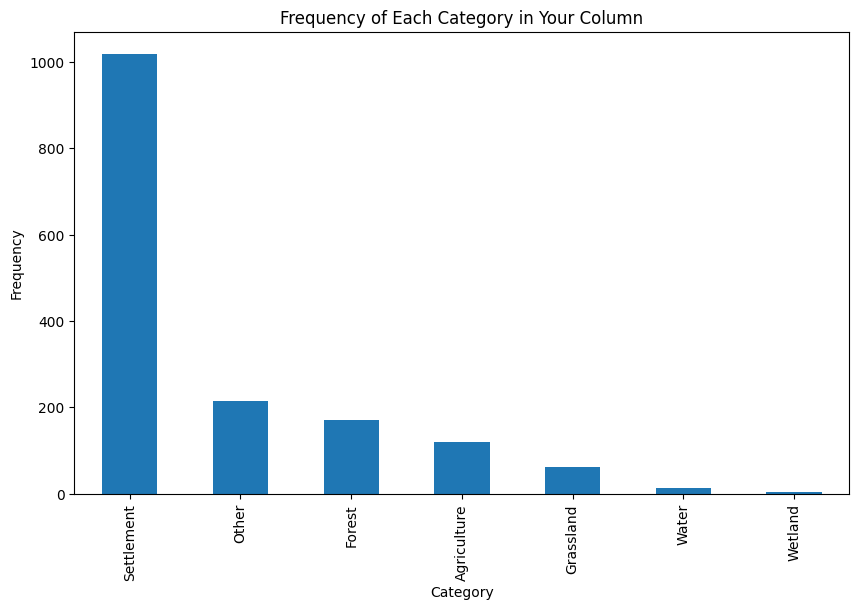

In [13]:
category_counts = df_select['IPCC Class'].value_counts()

# Plot the frequencies as a bar plot
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')

# Add title and labels
plt.title('Frequency of Each Category in Your Column')
plt.xlabel('Category')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [14]:
landcover_folders = []
aoi_names_set = set(df_select['aoi_name'])

# Loop over the directories in lr_dataset
for folder_name in os.listdir(lr_dataset_path):
    if folder_name in aoi_names_set:
        landcover_folders.append(folder_name)
    # Stop when 1000 folders have been added
    if len(landcover_folders) >= 1000:
        break

#print(landcover_folders)

In [ ]:
# upscale the low-resolution images
target_size_hr = (500, 500)  # assuming the target size for SRCNN is (500, 500)
target_size_lr = (500, 500)
sample_images = process_aois(landcover_folders, target_size_hr, target_size_lr, num_revisits)

In [ ]:
# Observe the loaded images in the dataset
for i in range(20):
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.title('High Resolution Image', color = 'green', fontsize = 20)
    plt.imshow(sample_images[landcover_folders[i]][1][0])
    plt.subplot(1,2,2)
    plt.title('Low Resolution Image', color = 'red', fontsize = 20)
    plt.imshow(sample_images[landcover_folders[i]][0][0])

### Prepare Train, Test, and Validation

In [18]:
# Collect all high-res and low-res images from sample_images
all_high_images = []
all_low_images = []

for aoi_name in sample_images:
    all_low_images.extend(sample_images[aoi_name][0])  # Low-resolution images
    all_high_images.extend(sample_images[aoi_name][1])  # High-resolution images

# Convert lists to numpy arrays
all_high_images = np.array(all_high_images)
all_low_images = np.array(all_low_images)

# Split the data into train, validation, and test sets
train_high_image = all_high_images[:800]
train_low_image = all_low_images[:800]

validation_high_image = all_high_images[800:900]
validation_low_image = all_low_images[800:900]

test_high_image = all_high_images[900:]
test_low_image = all_low_images[900:]

# Print the shapes to verify
print("Shape of training images:", train_high_image.shape)
print("Shape of test images:", test_high_image.shape)
print("Shape of validation images:", validation_high_image.shape)

print("Shape of training low images:", train_low_image.shape)
print("Shape of test low images:", test_low_image.shape)
print("Shape of validation low images:", validation_low_image.shape)

Shape of training images: (800, 500, 500, 3)
Shape of test images: (100, 500, 500, 3)
Shape of validation images: (100, 500, 500, 3)
Shape of training low images: (800, 500, 500, 3)
Shape of test low images: (100, 500, 500, 3)
Shape of validation low images: (100, 500, 500, 3)


### MODEL

In [19]:
from keras import layers
from tensorflow.keras.utils import plot_model

In [20]:
input_img=Input(shape=(500,500,3))
l1=tf.keras.layers.Conv2D(64,9,padding='same',activation='relu') (input_img)
l2=tf.keras.layers.Conv2D(32,1,padding='same',activation='relu') (l1)
l3=tf.keras.layers.Conv2D(3,5,padding='same',activation='relu') (l2)

SRCNN=Model(input_img,l3)

def pixel_mse_loss(x,y):
    return tf.reduce_mean( (x - y) ** 2 )

SRCNN.compile(optimizer=tf.keras.optimizers.legacy.Adam(0.001),loss=pixel_mse_loss)
# SRCNN.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=pixel_mse_loss)

SRCNN.summary()

plot_model(SRCNN, to_file ='super_res.png',show_shapes=True)

2024-07-29 21:49:41.358448: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-07-29 21:49:41.361018: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-29 21:49:41.361034: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-29 21:49:41.361595: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-29 21:49:41.362077: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500, 500, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 500, 500, 64)      15616     
                                                                 
 conv2d_1 (Conv2D)           (None, 500, 500, 32)      2080      
                                                                 
 conv2d_2 (Conv2D)           (None, 500, 500, 3)       2403      
                                                                 
Total params: 20099 (78.51 KB)
Trainable params: 20099 (78.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Training

In [21]:
SRCNN.fit(
    train_low_image,
    train_high_image,
    epochs = 50,
    batch_size = 10,
    validation_data = (validation_low_image,validation_high_image)
)

Epoch 1/50


2024-07-29 21:50:51.954773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


80/80 [==============================] - ETA: 0s - loss: 0.0173

2024-07-29 21:51:29.765821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


80/80 [==============================] - 41s 486ms/step - loss: 0.0173 - val_loss: 0.0130
Epoch 2/50
80/80 [==============================] - 38s 469ms/step - loss: 0.0133 - val_loss: 0.0138
Epoch 3/50
80/80 [==============================] - 38s 470ms/step - loss: 0.0134 - val_loss: 0.0134
Epoch 4/50
80/80 [==============================] - 39s 483ms/step - loss: 0.0135 - val_loss: 0.0127
Epoch 5/50
80/80 [==============================] - 38s 477ms/step - loss: 0.0131 - val_loss: 0.0123
Epoch 6/50
80/80 [==============================] - 38s 471ms/step - loss: 0.0134 - val_loss: 0.0126
Epoch 7/50
80/80 [==============================] - 38s 471ms/step - loss: 0.0136 - val_loss: 0.0126
Epoch 8/50
80/80 [==============================] - 38s 478ms/step - loss: 0.0134 - val_loss: 0.0126
Epoch 9/50
80/80 [==============================] - 38s 476ms/step - loss: 0.0127 - val_loss: 0.0135
Epoch 10/50
80/80 [==============================] - 38s 474ms/step - loss: 0.0129 - val_loss: 0.0134


### Define Image Quality Metrics

In [23]:
from skimage.metrics import structural_similarity as ssim
import math

def psnr(target, ref):
    """
    Compute the Peak Signal-to-Noise Ratio (PSNR) between two images.

    PSNR is used to measure the quality of reconstruction of lossy compression codecs.
    The signal is the original data, and the noise is the error introduced by compression.

    Args:
        target (numpy.ndarray): The target (reference) image.
        ref (numpy.ndarray): The reference image to compare against.

    Returns:
        float: The PSNR value in decibels (dB).

    """
    target_data = target.astype(float)
    ref_data = ref.astype(float)
    
    diff = ref_data-target_data
    diff = diff.flatten('C') # need ot flatten so computations can be done
    
    rmse = math.sqrt(np.mean(diff**2.))
    
    return 20 * math.log10(255./rmse)


def mse(target,ref):
    """
    Compute the Mean Squared Error (MSE) between two images.

    MSE is a risk function corresponding to the expected value of the squared error loss.
    It is used to measure the average of the squares of the errors, i.e., the average squared difference
    between the estimated values and the actual value.

    Args:
        target (numpy.ndarray): The target (reference) image.
        ref (numpy.ndarray): The reference image to compare against.

    Returns:
        float: The MSE value.

    """
    err=np.sum((target.astype('float')-ref.astype('float'))**2)
    err=err/float(target.shape[0]*target.shape[1]) # divided by total number of pixels
    
    return err


def compare_images(target,ref):
    """
    Compute the PSNR, MSE, and SSIM between two images.

    This function combines three image quality metrics:
    - Peak Signal-to-Noise Ratio (PSNR)
    - Mean Squared Error (MSE)
    - Structural Similarity Index (SSIM)

    Args:
        target (numpy.ndarray): The target (reference) image.
        ref (numpy.ndarray): The reference image to compare against.

    Returns:
        list: A list containing the PSNR, MSE, and SSIM values, respectively.

    """
    scores=[
        psnr(target, ref),
        mse(target, ref),
        ssim(target, ref, win_size=11, channel_axis=2, data_range=255)
    ]

    return scores


### Testing

In [24]:
pred_image = SRCNN.predict(test_low_image)

2024-07-29 22:26:41.080392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 3s 614ms/step


In [25]:
# Post-process predictions
pred_image *= 255
pred_image = pred_image.astype(np.uint8)

In [26]:
# Initialize list to hold scores for all images
pred_scores = []
original_scores = []

# Iterate over each image to compute the quality metrics
for i in range(len(test_low_image)):
    pred = pred_image[i]
    original = test_low_image[i] * 255
    truth = test_high_image[i] * 255

    pred_scores.append(compare_images(pred, truth))
    original_scores.append(compare_images(original, truth))

### Visualize the results

In [ ]:
for i in range(len(test_low_image)):
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    
    axs[0].imshow(test_low_image[i])
    axs[0].set_title('Low Resolution')
    axs[0].set(xlabel = 'PSNR: {}\nMSE: {} \nSSIM: {}'.format(original_scores[i][0], original_scores[i][1], original_scores[i][2]))

    axs[1].imshow(pred_image[i])
    axs[1].set_title('High Resolution (SRCNN)')
    axs[1].set(xlabel = 'PSNR: {}\nMSE: {} \nSSIM: {}'.format(pred_scores[i][0], pred_scores[i][1], pred_scores[i][2]))

    axs[2].imshow(test_high_image[i])
    axs[2].set_title('High Resolution')

### Effectiveness
Compare the PSNR/MSE/SSIM of the original low-resolution image and the processed images generated by the model

In [29]:
# Extract PSNR, MSE, and SSIM for plotting
original_psnr = [score[0] for score in original_scores]
original_mse = [score[1] for score in original_scores]
original_ssim = [score[2] for score in original_scores]
pred_psnr = [score[0] for score in pred_scores]
pred_mse = [score[1] for score in pred_scores]
pred_ssim = [score[2] for score in pred_scores]

# Calculate percentage increase
psnr_increase = [(p - o) / o * 100 for p, o in zip(pred_psnr, original_psnr)]
mse_increase = [(p - o) / o * 100 for p, o in zip(pred_mse, original_mse)]
ssim_increase = [(p - o) / o * 100 for p, o in zip(pred_ssim, original_ssim)]

# Number of test images
num_images = len(original_scores)
image_indices = range(num_images)

In [ ]:
# Plot percentage increase for PSNR
plt.figure(figsize=(14, 6))
plt.bar(image_indices, psnr_increase, color='blue')
plt.xlabel('Test Image Index')
plt.ylabel('Percentage Increase (%)')
plt.title('Percentage Change in PSNR')
plt.show()
# Plot PSNR comparison
plt.figure(figsize=(12, 6))
plt.plot(range(num_images), original_psnr, label='Original Low-Res PSNR', marker='o')
plt.plot(range(num_images), pred_psnr, label='Generated High-Res PSNR', marker='x')
plt.xlabel('Test Image Index')
plt.ylabel('PSNR')
plt.title('PSNR Comparison')
plt.legend()
plt.show()

In [ ]:
# Plot percentage increase for MSE
plt.figure(figsize=(14, 6))
plt.bar(image_indices, mse_increase, color='green')
plt.xlabel('Test Image Index')
plt.ylabel('Percentage Increase (%)')
plt.title('Percentage Change in MSE')
plt.show()
# Plot MSE comparison
plt.figure(figsize=(12, 6))
plt.plot(range(num_images), original_mse, label='Original Low-Res MSE', marker='o')
plt.plot(range(num_images), pred_mse, label='Generated High-Res MSE', marker='x')
plt.xlabel('Test Image Index')
plt.ylabel('MSE')
plt.title('MSE Comparison')
plt.legend()
plt.show()

In [ ]:
# Plot percentage increase for SSIM
plt.figure(figsize=(14, 6))
plt.bar(image_indices, ssim_increase, color='purple')
plt.xlabel('Test Image Index')
plt.ylabel('Percentage Increase (%)')
plt.title('Percentage Change in SSIM')
plt.show()
# Plot SSIM comparison
plt.figure(figsize=(12, 6))
plt.plot(range(num_images), original_ssim, label='Original Low-Res SSIM', marker='o')
plt.plot(range(num_images), pred_ssim, label='Generated High-Res SSIM', marker='x')
plt.xlabel('Test Image Index')
plt.ylabel('SSIM')
plt.title('SSIM Comparison')
plt.legend()
plt.show()